In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import imageio.v2 as imageio
import time
import torchvision
import src.vision as vision
from PIL import Image

from src.vision.nerf_trainer import Trainer
from src.vision.nerf_model_logic import NerfModel
from tqdm.notebook import tqdm


device_type = (
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
device = torch.device(device_type)
print(device)

%load_ext autoreload
%autoreload 2

cuda


In [2]:
from ipywidgets import interact, IntSlider

In [3]:

def display_img(index: int, scene: str="lego", split: str="train"):
    
    root_dir = f"./nerf_synthetic/{scene}/{split}"
    root_path = os.path.expanduser(root_dir)
    image_name = f"r_{index}.png"
    image_path = os.path.join(root_path, image_name)
    # hard_code_path = "./nerf_synthetic/lego/train/r_24.png"

    if os.path.exists(image_path):
        img = Image.open(image_path).convert('RGB')

        plt.figure(figsize=(8,8))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{image_name} | Shape:")
        plt.show()

    else:
        print(f"File {image_name} not found in {root_dir}")


In [4]:

interact(display_img, index=IntSlider(min=0, max=99, step=1, value=24, description="Image index: "))
# display(img)
# img_array = np.array(img)
# print(f"Image shape (H, W, C): {img_array.shape}")

interactive(children=(IntSlider(value=24, description='Image index: ', max=99), Text(value='lego', description…

<function __main__.display_img(index: int, scene: str = 'lego', split: str = 'train')>

In [5]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [6]:

torch.cuda.empty_cache()
# Hyperparameters & Paths
data_dir = "./nerf_synthetic/lego/"
model_dir = "./checkpoints/"
# near_t, far_t = 2.0, 6.0
near_t, far_t = 0.667, 2.0
num_frequencies=(10,4) # works for (6,4) but fails for (4,4)??????
# paper uses (10, 4)

# Initialize Model & Optimizer
# Note: encode_channels should match your positional encoding frequencies
encode_channels = (num_frequencies[0] * 2 * 3) + 3 # (num_freqs * 2 * dimensions) + input
model = NerfModel(encode_channels,filter_size=256, freq=num_frequencies).to(device)
# model.apply(weights_init)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

test_image_path = "C:/Users/The_M/Documents/GeorgiaTech/cs6476/project-6-student/nerf_synthetic/lego/train/r_24.png"
testimg = Image.open(test_image_path).convert('RGB')
new_size = (100, 100)
testimg = testimg.resize(new_size, Image.Resampling.LANCZOS)
testimg_tensor = torchvision.transforms.ToTensor()(testimg).permute(1,2,0)
print(testimg_tensor.shape)
### Change this for every tiem the test_image changes!!! ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
testpose = torch.tensor([
                [
                    0.7739522457122803,
                    0.35971799492836,
                    -0.5211533904075623,
                    -2.1008365154266357
                ],
                [
                    -0.633243978023529,
                    0.4396481513977051,
                    -0.6369548439979553,
                    -2.5676472187042236
                ],
                [
                    0.0,
                    0.8229899406433105,
                    0.5680559277534485,
                    2.2899067401885986
                ],
                [
                    0.0,
                    0.0,
                    0.0,
                    1.0
                ]
            ])

# testpose *= (new_size[0]/800)
testpose[:3, 1:3] *= -1  # Flip Y and Z axes (OpenGL -> OpenCV)
testpose[:3, 3] /= 3.0
# testpose[-1, -1] = 1.0

torch.Size([100, 100, 3])


In [7]:
rays_per_batch = 8192
epochs = 3
trainer_loop = Trainer(
    data_dir = data_dir,
    model_dir=model_dir,
    model=model,
    optimizer=optimizer,
    device=device_type,
    near_thresh = near_t,
    far_thresh = far_t,
    testpose=testpose,
    testimg=testimg_tensor,
    batch_size = 1,
    rays_per_batch = rays_per_batch,
    load_from_disk = False,
    cuda = True,
    num_frequencies=num_frequencies,
    scaled_size=new_size
)

model_dl, encode_pts_dl, encode_view_dl, training_snaps_rgb_dl, training_snaps_depth_dl = trainer_loop.run_training_loop(epochs, 50, batched=True)
torch.save(model_dl.state_dict(), os.path.join('output', f'nerf_model_(testing_batched_({new_size})_{epochs}e_{rays_per_batch}r).pth'))
# model_dl, encode_pts_dl, encode_view_dl, training_snaps_rgb_dl, training_snaps_depth_dl = trainer_loop.run_training_loop(50, 50, batched=True)
# torch.save(model_dl.state_dict(), os.path.join('output', 'nerf_model_(testing_batched_(800x800)_80e_8192r).pth'))

Training completed!
(6, 100, 100, 3) (6, 100, 100)


In [8]:

# model_dl, encode_pts_dl, encode_view_dl, training_snaps_rgb_dl, training_snaps_depth_dl = trainer_loop.run_training_loop(2, 50, batched=True)

# output_path = os.path.join('output/model_checkpoints/nerf', 'nerf_model_(testing_batch_(200x200)_30e_4096r).pth')

# torch.save(model_dl.state_dict(), output_path)

  0%|          | 0/2 [00:00<?, ?it/s]

Starting Epoch 0


ProcessingBatches:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

nerf_synthetic\lego\train\r_0.png


interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

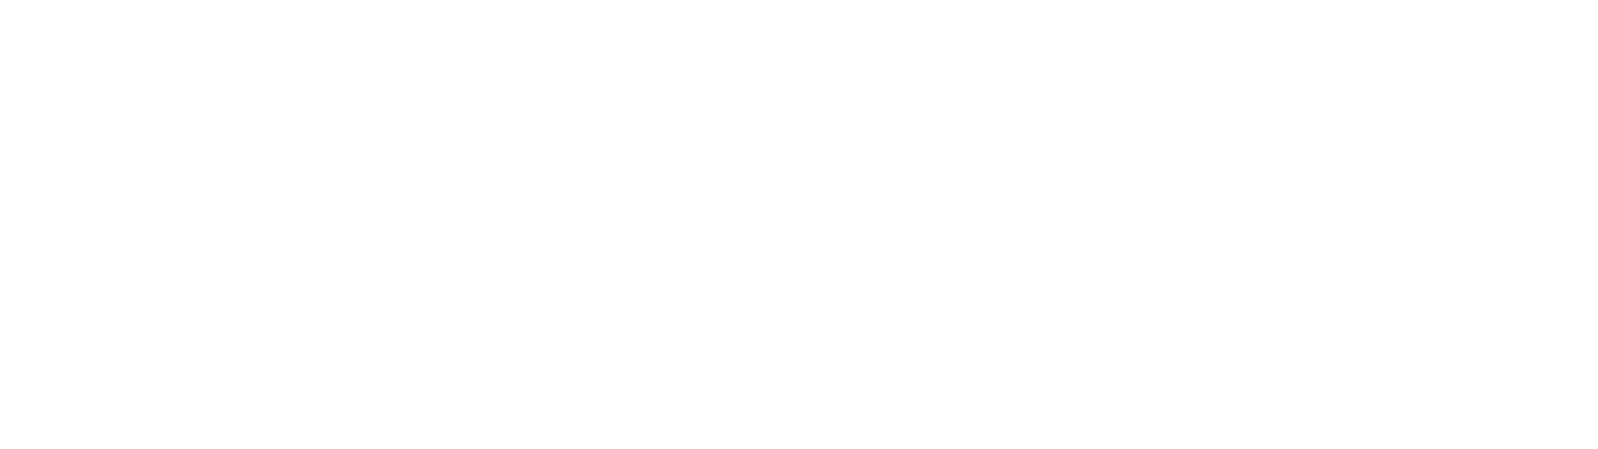

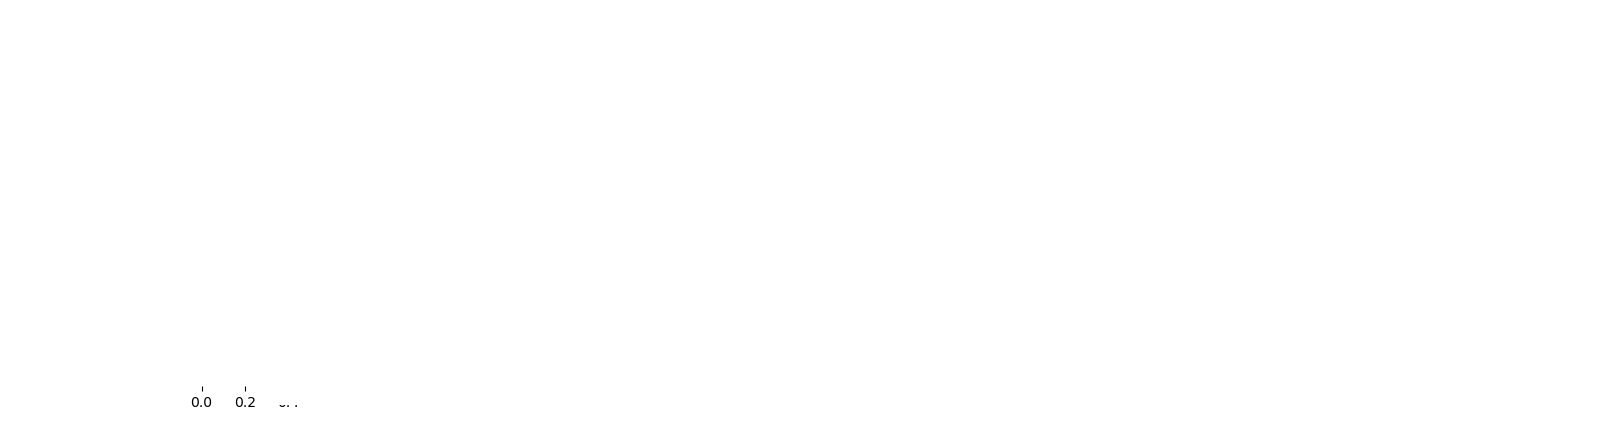

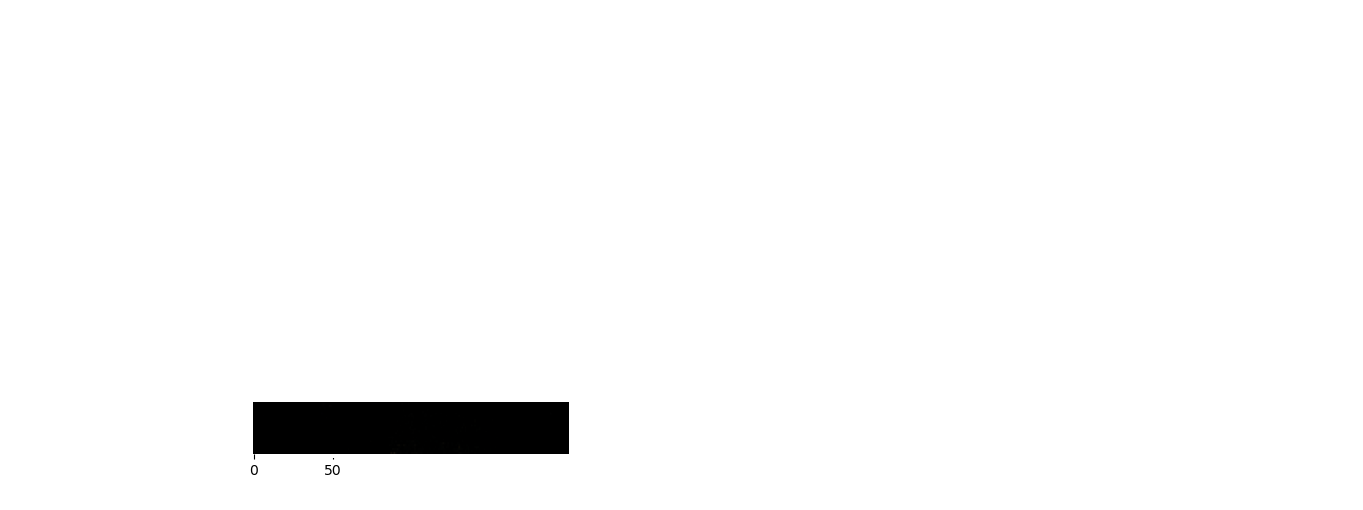

In [9]:
from src.vision.part2_view_dep import render_image_nerf, render_full_image_chunked
import src.vision.nerf_dataloader as nerf_dataloader

trans_t = lambda t : np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=np.float32)

rot_phi = lambda phi : np.array([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1],
], dtype=np.float32)

rot_theta = lambda th : np.array([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1],
], dtype=np.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    c2w = c2w @ np.array([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
    c2w = np.array(c2w, dtype=np.float32)
    return c2w
    
dataset = nerf_dataloader.SpatialImg(
    root_dir="./nerf_synthetic/lego/",
    split="train",
    scaled_size=(200, 200)
)

%matplotlib inline
from ipywidgets import interactive, widgets
def f(**kwargs):
    render_poses = torch.from_numpy(pose_spherical(**kwargs)).to(device)
    rgb_predicted, depth_predicted = render_full_image_chunked(200, 200, dataset.cam_intrinsics.to(device),
                                              render_poses[:3,:4], near_t,
                                              far_t, 64,
                                              encode_pts_dl, encode_view_dl, model_dl)
    img = np.clip(rgb_predicted.detach().cpu().numpy(),0,1)
    dpimg = np.clip(depth_predicted.detach().cpu().numpy(),0,1)
    
    fig, axes = plt.subplots(1, 2, figsize=(20,6))
    
    # axes[0].figure(2, figsize=(20,6))
    axes[0].imshow(img)
    axes[1].imshow(dpimg)
    display(fig)

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [1.5, 1., 2.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '450px'
interactive_plot

In [7]:
import imageio
# 360 video
import tqdm

with torch.no_grad():
  rgbs = []
  depths = []
  for th in tqdm.tqdm(np.linspace(0., 360., 120, endpoint=False)):
      render_poses = torch.from_numpy(pose_spherical(th, -30., 1.4)).to(device)
      rgb_predicted, d_pred = render_full_image_chunked(200, 200, dataset.cam_intrinsics.to(device),
                                              render_poses[:3,:4], near_t,
                                              far_t, 64,
                                              encode_pts_dl, encode_view_dl, model_dl)
      rgbs.append(rgb_predicted.detach().cpu().numpy())
      depths.append(d_pred.detach().cpu().numpy())
rgbs = np.array(rgbs)
depths = np.array(depths)
print('Done, saving', rgbs.shape)
moviebase = os.path.join('{}_spiral_(testing_batch_(800x800)_80e_8192r)_'.format("lego"))
to8b = lambda x : (255*np.clip(x,0,1)).astype(np.uint8)
imageio.mimwrite(moviebase + 'rgb.mp4', to8b(rgbs), fps=30, quality=8)
imageio.mimwrite(moviebase + 'depth.mp4', to8b(depths), fps=30, quality=8)

from IPython.display import HTML
from base64 import b64encode
mp4 = open(moviebase + 'rgb.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [01:26<00:00,  1.38it/s]


Done, saving (120, 200, 200, 3)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 200) to (208, 208) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (200, 200) to (208, 208) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [8]:
mp4 = open(moviebase + 'depth.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
so it works when i try using full render image fhunked in trianing
somethign a bout the validation code makes the plot not actaully compute correctly?
somethign about the test image and test pose perhpas?

tried applying the appropriate xyz axis correction on the testpose 